In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob
import os

In [2]:
rel_data_dir_full = './data/sharew8_all/'
rel_data_dir_easy = './data/sharew8_easy/'
plot_dir = './plots/'
outdir = './'

In [3]:
'''
Wave 8 Release 8.0.0
DOI: 10.6103/SHARE.w8.800
2022-02-10 00:53:53
'''
all_files = glob(f"{rel_data_dir_full}*.dta")

'''
easySHARE Release 8.0.0
DOI: 10.6103/SHARE.easy.800
2022-02-10 01:00:22
'''
easy_files = glob(f"{rel_data_dir_easy}*.dta")

'''
Wave 8 Accelerometer Epochs Release 8.0.0
DOI: 10.6103/SHARE.w8.800
2022-02-10 01:04:04
'''
acc_files = glob(f"{rel_data_dir_full}dta/**/*.dta", recursive=True)

Loading the datasets from SHARE 

In [4]:
df_easy = pd.read_stata(easy_files[0])
df_ph = pd.read_stata(os.path.join(rel_data_dir_full, 'sharew8_rel8-0-0_ph.dta'))
df_acc_hr = pd.read_stata(os.path.join(rel_data_dir_full, 'sharew8_rel8-0-0_gv_accelerometer_hour.dta'))
df_acc = pd.read_stata(os.path.join(rel_data_dir_full, 'sharew8_rel8-0-0_gv_accelerometer_total.dta'))
df_acc_imp = pd.read_stata(os.path.join(rel_data_dir_full, 'sharew8_rel8-0-0_gv_imputations.dta'))
df_acc_hr_clean = df_acc_hr.iloc[:,0:15]

Data prep

In [5]:
df_acc_hr_clean.loc[:, 'OxCGRT_stay_at_home'] = df_acc_hr_clean['OxCGRT_stay_at_home'].replace({
    'No measures': 'No restrictions',
    "Require not leaving house with exceptions for daily exercise, grocery shopping, and 'essential' trips": 'Essential only',
    "Recommend not leaving house": 'Stay at home',
})

In [6]:
def get_common_columns(df1, df2, merge_on=['mergeid']):
    common = df1.columns.difference(df2.columns).tolist()
    common.extend(merge_on)
    return common

In [7]:
df = df_acc_hr_clean.copy()
df = pd.merge(left=df, left_on=['mergeid'], right=df_ph[get_common_columns(df_ph, df)], right_on=['mergeid'], how='left')
df = pd.merge(left=df, left_on=['mergeid'], right=df_acc[get_common_columns(df_acc, df)], right_on=['mergeid'], how='left')
df = pd.merge(left=df, left_on=['mergeid'], right=df_easy[get_common_columns(df_easy, df)], right_on=['mergeid'], how='left')

df = df[df['wave'] == 8]

In [8]:
def map_selected_num(df, columns: list[str]):
    df = df.copy()
    for c in columns:
        df.loc[:, c] = df[c].map({
            'Selected': 1,
            'Not selected': 0,
            "Don't know": -1,
            'Refusal': -2,
            1: 1,
            0: 0,
            -1: -1,
            -2: -2,
        })
    return df

In [9]:
#                        Hypertension, Diabetis, Osteoarthritis, pain hips, pain knee
df = map_selected_num(df, ['ph006d2', 'ph006d5', 'ph006d20', 'ph087d2', 'ph087d3'])

Defining Osteoarthritis 

ph006d20: Osteoarthritis/other rheumatism: ever diagnosed/currently having

ph087d2: Pain location: hips or
ph087d3: Pain location: knees


d1: Hypertension

d2: Diabetes

d3: OA (in hip/knee)

d4: Hypertension + Diabetes

d5: Hypertension + OA

d6: Diabetes + OA

d7: Hypertension + Diabetes + OA  

In [10]:
df['Hypertension'] = pd.to_numeric(df['ph006d2'])
df['Diabetes'] = pd.to_numeric(df['ph006d5'])
df['OA'] = np.where(((df['ph006d20'] == 1) & (df['ph087d2'] == 1)) | ((df['ph006d20'] == 1) & (df['ph087d3'] == 1)), 1, 0)

In [11]:
df['d1'] = np.where((df['Hypertension'] == 1) & (df['Diabetes'] == 0) & (df['OA'] == 0), int(1), int(0))
df['d2'] = np.where((df['Hypertension'] == 0) & (df['Diabetes'] == 1) & (df['OA'] == 0), int(1), int(0))
df['d3'] = np.where((df['Hypertension'] == 0) & (df['Diabetes'] == 0) & (df['OA'] == 1), int(1), int(0))
df['d4'] = np.where((df['d1'] == 1) & (df['d2'] == 1) & (df['d3'] == 0), int(1), int(0))
df['d5'] = np.where((df['d1'] == 1) & (df['d3'] == 1) & (df['d2'] == 0), int(1), int(0))
df['d6'] = np.where((df['d3'] == 1) & (df['d2'] == 1) & (df['d1'] == 0), int(1), int(0))
df['d7'] = np.where((df['d1'] == 1) & (df['d2'] == 1) & (df['d3'] == 1), int(1), int(0))
df['control'] = np.where((df['d1'] == 0) & (df['d2'] == 0) & (df['d3'] == 0), int(1), int(0))

In [12]:
df['disease'] = 'c'
df.loc[(df['d1'] == 1) & (df['d2'] == 0) & (df['d3'] == 0), 'disease'] = 'd1'
df.loc[(df['d1'] == 0) & (df['d2'] == 1) & (df['d3'] == 0), 'disease'] = 'd2'
df.loc[(df['d1'] == 0) & (df['d2'] == 0) & (df['d3'] == 1), 'disease'] = 'd3'
df.loc[(df['d1'] == 1) & (df['d2'] == 1) & (df['d3'] == 0), 'disease'] = 'd4'
df.loc[(df['d1'] == 1) & (df['d2'] == 0) & (df['d3'] == 1), 'disease'] = 'd5'
df.loc[(df['d1'] == 0) & (df['d2'] == 1) & (df['d3'] == 1), 'disease'] = 'd6'
df.loc[(df['d1'] == 1) & (df['d2'] == 1) & (df['d3'] == 1), 'disease'] = 'd7'
#df.loc[(df['d1'] == 0) & (df['d2'] == 0) & (df['d3'] == 0), 'disease'] = 'c'
df['disease'].value_counts()

c     93216
d1    43728
d3     8616
d2     8040
Name: disease, dtype: int64

In [41]:
'''
df['disease'] = pd.np.where(df['d1'] == 1, "d1",
                   pd.np.where(df['d2'] == 1, "d2",
                   pd.np.where(df['d3'] == 1, "d3",
                   pd.np.where(df['d4'] == 1, "d4",
                   pd.np.where(df['d5'] == 1, "d5",
                   pd.np.where(df['d6'] == 1, "d6",
                   pd.np.where(df['d7'] == 1, "d7",
                   pd.np.where(df['control'] == 1, "c", 0))))))))
df['disease'].value_counts()
'''

C:\Users\mjbur\AppData\Local\Temp\ipykernel_33308\1437158587.py:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df['disease'] = pd.np.where(df['d1'] == 1, "d1",
C:\Users\mjbur\AppData\Local\Temp\ipykernel_33308\1437158587.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  pd.np.where(df['d2'] == 1, "d2",
C:\Users\mjbur\AppData\Local\Temp\ipykernel_33308\1437158587.py:3: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  pd.np.where(df['d3'] == 1, "d3",
C:\Users\mjbur\AppData\Local\Temp\ipykernel_33308\1437158587.py:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  pd.np.where(df['d4'] == 1, "d4",
C:\Users\mjbur\AppData\Local\Temp\ipyker

c     82608
d1    38544
d3     7752
d2     7128
Name: disease, dtype: int64

In [13]:
def map_bmi_num(df, columns: list[str] = ['bmi']):
    df = df.copy()
    for c in columns:
        df.loc[:, c] = df[c].replace({
            '-15. no information': -1,
            '-13. not asked in this wave': -1,
            "-12. don't know / refusal": -1,
            '-3. implausible value/suspected wrong': -1,
        })
        df[c] = df[c].astype(float)
    return df

In [14]:
df = map_bmi_num(df)

In [15]:
df['female'] = pd.to_numeric(df['female'].replace({'1. female': 1, '0. male': 0}))
df.loc[:, 'age'] = df.replace({'-15. no information': -1})
df.loc[:, 'age'] = df['age'].astype(float)

In [43]:
groups = ['d1','d2','d3', 'd4','d5','d6','d7','control']

In [45]:
df_stat = df[['mergeid', 'female', 'age', 'bmi', 'GGIR_mean_ENMO_hour','GGIR_N_valid_hours','hour','measurementday','weekday','month','year','device_id', 'frequency', 'position', 'country',
'd1','d2','d3', 'd4','d5','d6','d7','control', 'disease']].copy()
df_stat.rename(columns={'GGIR_mean_ENMO_hour': 'ENMO_hour'}, inplace=True)

In [46]:
df_stat

,mergeid,female,age,bmi,ENMO_hour,GGIR_N_valid_hours,hour,measurementday,weekday,month,...,country,d1,d2,d3,d4,d5,d6,d7,control,disease
4,Bf-031257-01,0,67.000000,21.155294,6.697222,0.0,12am-1am,1,Tuesday,February,...,Belgium,0,0,0,0,0,0,0,1,c
9,Bf-031257-01,0,67.000000,21.155294,10.741667,0.0,1am-2am,1,Tuesday,February,...,Belgium,0,0,0,0,0,0,0,1,c
14,Bf-031257-01,0,67.000000,21.155294,7.848472,0.5,2am-3am,1,Tuesday,February,...,Belgium,0,0,0,0,0,0,0,1,c
19,Bf-031257-01,0,67.000000,21.155294,0.244306,1.0,3am-4am,1,Tuesday,February,...,Belgium,0,0,0,0,0,0,0,1,c
24,Bf-031257-01,0,67.000000,21.155294,4.214167,1.0,4am-5am,1,Tuesday,February,...,Belgium,0,0,0,0,0,0,0,1,c
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799419,SI-992596-02,0,73.199997,30.864197,14.941944,1.0,7pm-8pm,7,Thursday,January,...,Slovenia,0,1,0,0,0,0,0,0,d2
799424,SI-992596-02,0,73.199997,30.864197,4.990833,1.0,8pm-9pm,7,Thursday,January,...,Slovenia,0,1,0,0,0,0,0,0,d2
799429,SI-992596-02,0,73.199997,30.864197,10.771528,1.0,9pm-10pm,7,Thursday,January,...,Slovenia,0,1,0,0,0,0,0,0,d2
799434,SI-992596-02,0,73.199997,30.864197,12.281944,1.0,10pm-11pm,7,Thursday,January,...,Slovenia,0,1,0,0,0,0,0,0,d2


Export to csv

In [25]:
# Export Dataframe to csv-file 
df_stat.to_csv(r'merged_data.csv', index = False)

Summarize ENMO (mean, median, var) per respondent

In [37]:
def calc_ENMO_stats(df, enmo_col='ENMO_hour'):
    df = df.copy()
    mean = df.groupby('mergeid')[enmo_col].mean()
    median = df.groupby('mergeid')[enmo_col].median()
    var = df.groupby('mergeid')[enmo_col].var()
    mean.name = 'mean_ENMO'
    median.name = 'median_ENMO'
    var.name = 'var_ENMO'
    df = pd.merge(left=df, left_on='mergeid', right=mean, right_on='mergeid', how='left')
    df = pd.merge(left=df, left_on='mergeid', right=median, right_on='mergeid', how='left')
    df = pd.merge(left=df, left_on='mergeid', right=var, right_on='mergeid', how='left')
    return df

In [40]:
df_summarize = calc_ENMO_stats(df_stat)   
df_summarize = df_summarize.drop_duplicates(subset='mergeid', keep='first')
cols = ['ENMO_hour','GGIR_N_valid_hours', 'hour', 'measurementday', 'weekday']
df_summarize.drop(cols, inplace=True, axis=1)
df_summarize

,mergeid,female,age,bmi,month,year,device_id,frequency,position,country,...,d3,d4,d5,d6,d7,control,disease,mean_ENMO,median_ENMO,var_ENMO
0,Bf-031257-01,0,67.000000,21.155294,February,2020,68652.0,50,Left,Belgium,...,0,0,0,0,0,1,c,12.190145,9.553125,111.652721
216,Bf-043946-02,1,57.299999,38.446751,February,2020,30920.0,50,Left,Belgium,...,0,0,0,0,0,0,d1,14.298743,8.866736,218.204196
408,Bf-073169-01,0,72.500000,25.209202,March,2020,68652.0,50,Right,Belgium,...,0,0,0,0,0,0,d1,15.879468,11.452292,495.595913
600,Bf-227520-04,0,56.099998,24.593210,March,2020,17212.0,50,Right,Belgium,...,0,0,0,0,0,0,d1,11.543128,11.326111,74.794850
648,Bf-286437-02,1,68.099998,30.778702,February,2020,54007.0,50,Right,Belgium,...,0,0,0,0,0,0,d1,38.811152,48.127569,367.199181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152664,SI-962639-01,0,72.900002,26.296566,January,2020,52614.0,50,Left,Slovenia,...,0,0,0,0,0,1,c,12.875293,9.565347,141.034209
152880,SI-971713-02,1,54.299999,24.690405,February,2020,94219.0,50,Right,Slovenia,...,0,0,0,0,0,0,d1,44.210360,45.169444,704.042868
153048,SI-972188-01,1,80.900002,14.056643,December,2019,53941.0,50,Left,Slovenia,...,0,0,0,0,0,1,c,44.399227,36.005139,1161.445299
153240,SI-981265-01,1,67.199997,33.462223,February,2020,20461.0,50,Right,Slovenia,...,0,0,0,0,0,1,c,16.416532,15.242778,132.150018


long to wide format

In [67]:
df_stat.drop(df_stat[df_stat.measurementday > 7].index, inplace=True)
df_wide = df_stat.pivot_table(index=['mergeid', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'control', 'disease'], 
                                columns='measurementday', values='ENMO_hour', aggfunc={'ENMO_hour': np.mean})
df_wide.dropna(inplace=True)
df_wide

,,,,,,,,,measurementday,1,2,3,4,5,6,7
mergeid,d1,d2,d3,d4,d5,d6,d7,control,disease,,,,,,,
Bf-031257-01,0,0,0,0,0,0,0,1,c,7.842784,13.951765,14.691516,11.845631,15.103767,8.624473,13.088953
Bf-043946-02,1,0,0,0,0,0,0,0,d1,14.734543,12.709763,11.554774,15.158368,8.666696,16.909890,16.726105
Bf-073169-01,1,0,0,0,0,0,0,0,d1,25.244525,10.036458,12.613015,11.006794,21.812749,15.087454,16.835509
Bf-291361-02,0,0,0,0,0,0,0,1,c,42.403131,53.354855,53.780660,45.536817,44.093501,42.671858,40.565764
Bf-294636-01,0,0,0,0,0,0,0,1,c,19.117378,15.019144,14.817222,15.841696,16.929803,16.612344,19.187679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SI-962639-01,0,0,0,0,0,0,0,1,c,14.375955,11.102760,10.591551,15.852465,11.629236,12.166458,14.049485
SI-971713-02,1,0,0,0,0,0,0,0,d1,39.964954,42.500087,46.130376,44.772338,40.468032,41.763299,53.873432
SI-972188-01,0,0,0,0,0,0,0,1,c,48.016904,50.310799,54.766192,41.183137,37.529161,51.809444,35.251372


Statistics - MANOVA

In [35]:
from statsmodels.multivariate.manova import MANOVA

maov = MANOVA.from_formula('1,2,3,4,5,6,,7 ~ d1+d2+d3+c', data=df_wide)
print(maov.mv_test())

PatsyError: Error evaluating factor: NameError: name 'd1' is not defined
    measurementday ~ d1
                     ^^

In [21]:
from dfply import *
df_stat >> group_by(X.mergeid) >> summarize(n=X['ENMO_hour'].count())  >> filter_by(X.n < 168)
# 24*7 = 168 --> should be 168 values at least for each respondent
# not the case here:

,mergeid,n
3,Bf-227520-04,48
4,Bf-286437-02,120
7,Bf-366932-01,144
10,Bf-590759-01,48
12,Bf-640794-01,96
...,...,...
801,SI-445393-01,144
807,SI-530797-01,144
815,SI-613476-01,144
826,SI-673422-04,72


In [22]:
df_stat >> group_by(X.disease) >> summarize(n=X['ENMO_hour'].count())

,disease,n
0,c,93216
1,d1,43728
2,d2,8040
3,d3,8616


In [23]:
df_stat >> group_by(X.mergeid) >> summarize(variance=X['ENMO_hour'].var(), std=X['ENMO_hour'].std())

,mergeid,variance,std
0,Bf-031257-01,111.652721,10.566585
1,Bf-043946-02,218.204196,14.771736
2,Bf-073169-01,495.595913,22.261984
3,Bf-227520-04,74.794850,8.648402
4,Bf-286437-02,367.199181,19.162442
...,...,...,...
851,SI-962639-01,141.034209,11.875782
852,SI-971713-02,704.042868,26.533806
853,SI-972188-01,1161.445299,34.079984
854,SI-981265-01,132.150018,11.495652


Visualize the data

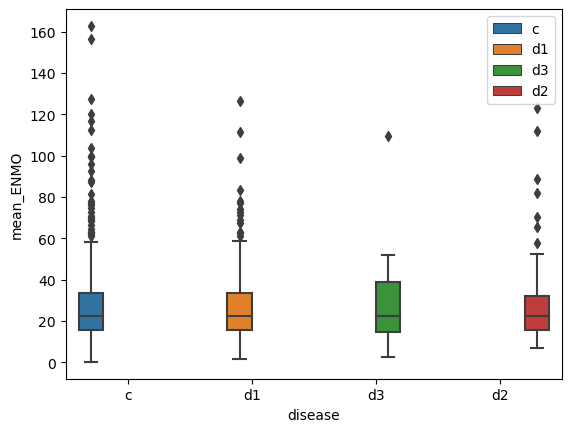

In [24]:
import seaborn as sns
sns.boxplot(data=df_summarize, x="disease", y="mean_ENMO", hue=df_summarize.disease.tolist())
plt.show()

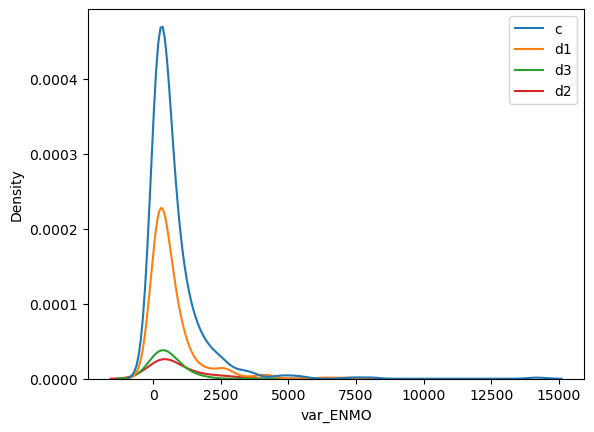

In [25]:
sns.kdeplot(data=df_summarize, x="var_ENMO", hue=df_summarize.disease.tolist())
plt.show()

Multivariate Analysis of Variance (MANOVA) using statsmodels

to test significance of the group differences 

In [26]:
from statsmodels.multivariate.manova import MANOVA

maov = MANOVA.from_formula('ENMO ~ d1+d2...', data=df_stat)
print(maov.mv_test())

                                    Multivariate linear model
                                                                                                  
--------------------------------------------------------------------------------------------------
       Intercept                Value          Num DF    Den DF            F Value          Pr > F
--------------------------------------------------------------------------------------------------
          Wilks' lambda               -0.0000 26.0000 153573.0000 -5320240812108999680.0000 1.0000
         Pillai's trace                1.0000 26.0000 153573.0000 -5320240812108998656.0000 1.0000
 Hotelling-Lawley trace -900719925474100.2500 26.0000 153573.0000 -5320240812108999680.0000 1.0000
    Roy's greatest root -900719925474100.2500 26.0000 153573.0000 -5320240812108999680.0000 1.0000
--------------------------------------------------------------------------------------------------
                                               

In [105]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda

X = df_stat[["d3", "control"]]
y = df_stat["ENMO_hour"]
y = y.astype(int)
post_hoc = lda().fit(X=X, y=y)

In [106]:
# get Prior probabilities of groups:
post_hoc.priors_
np.array([0.25, 0.25, 0.25, 0.25])

# get group means
post_hoc.means_
np.array([[18.9  ,  0.784],
       [16.54 ,  0.608],
       [ 3.05 ,  0.272],
       [ 9.35 ,  0.474]])

# get Coefficients of linear discriminants
post_hoc.scalings_
np.array([[-0.43883736, -0.2751091 ],
       [-1.39491582,  9.32562799]])

# get Proportion of trace (variance explained by each of the selected components)
post_hoc.explained_variance_ratio_
np.array([0.98545382, 0.01454618])


array([0.98545382, 0.01454618])

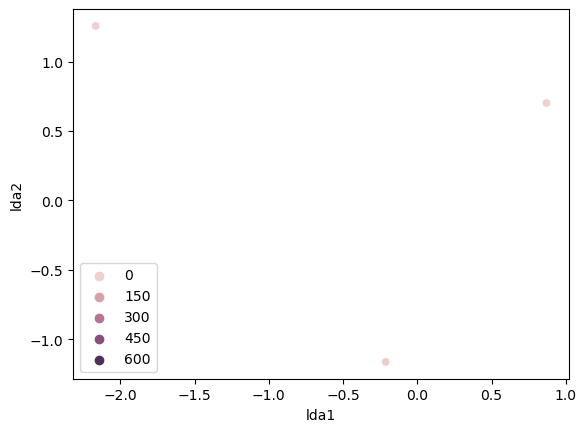

In [107]:
# plot 
X_new = pd.DataFrame(lda().fit(X=X, y=y).transform(X), columns=["lda1", "lda2"])
X_new["ENMO_hour"] = df_stat["ENMO_hour"]
sns.scatterplot(data=X_new, x="lda1", y="lda2", hue=df_stat.ENMO_hour.tolist())
plt.show()

p < 0.001 => ENMO has a statistically significant association with dieseases 

In [98]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

X = df_stat.iloc[:,[16,17]]
y = df_stat.iloc[:,4].values
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Feature Scaling to Dataset
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Implemented Linear Discriminant Analysis
lda = LDA(n_components = 2)
X_train = lda.fit_transform(X_train, y_train)
X_test = lda.transform(X_test)

# Train Logistic Regression with LDA
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Predict Results of Regression with LDA
y_pred = classifier.predict(X_test)

KeyboardInterrupt: 

Visualize

In [ ]:
from matplotlib.colors import ListedColormap

X_set, y_set = X_train, y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min()-1, stop = X_set[:, 0].max() + 1, step = 0.01), 
                        np.arange(start = X_set[:, 1].min()-1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
                alpha = 0.75, cmap = ListedColormap(('red', 'green', 'blue')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
    c = ListedColormap(('red', 'green', 'blue'))(i), label = j)
plt.title('Logistic Regression (Training set)')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend()
plt.show()

In [108]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

reg = ols('d1~ENMO_hour', data=df_stat).fit()
aov_d1 = sm.stats.anova_lm(reg, typ=2)
print(aov_d1)

                 sum_sq        df           F        PR(>F)
ENMO_hour     54.989915       1.0  223.444292  1.740582e-50
Residual   37800.656335  153598.0         NaN           NaN


In [109]:
reg = ols('d2~ENMO_hour', data=df_stat).fit()
aov_d1 = sm.stats.anova_lm(reg, typ=2)
print(aov_d1)

                 sum_sq        df          F    PR(>F)
ENMO_hour      1.366816       1.0  10.043718  0.001529
Residual   20902.633184  153598.0        NaN       NaN


In [110]:
reg = ols('d3~ENMO_hour', data=df_stat).fit()
aov_d1 = sm.stats.anova_lm(reg, typ=2)
print(aov_d1)

                 sum_sq        df           F        PR(>F)
ENMO_hour     12.200147       1.0  102.842763  3.692527e-24
Residual   18221.196103  153598.0         NaN           NaN


In [111]:
reg = ols('control~ENMO_hour', data=df_stat).fit()
aov_d1 = sm.stats.anova_lm(reg, typ=2)
print(aov_d1)

                 sum_sq        df           F        PR(>F)
ENMO_hour     36.638661       1.0  148.491158  3.841960e-34
Residual   37898.721339  153598.0         NaN           NaN
